#  Wavefield Simulations Using SPECFEM
## Notebook 2: Forward Simulations — Exercise Solutions

- Here we build upon material learned in Notebook 2
- This notebook allows Users to play around with their own SPECFEM2D homogeneous halfspace example in an exercise  
- **Objective:** Familiarize Users with setting `SOURCE` and `STATION` attributes, adjusting velocity model parameters, and assessing simulation results.
- These instructions can be run from inside a Docker container, using Jupyter Lab (see instructions [here](https://github.com/adjtomo/adjdocs/blob/main/readmes/docker_image_install.md)).  

-----------

**Relevant Links:** 
- Original Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2024-5-21_scoped_uw/2_forward_simulations.ipynb

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.
- To time a task, put a `%time` before the command (e.g., `%time ! ls`)


In [1]:
# Python packages required for this notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

---------------------
## 4) Forward Simulation Exercise

- Participants will now be asked to edit simulation parameters to run their own simulation  
- Some things that you are asked to try include:
    1) Change the parameters of the homogeneous halfspace model defined in the `Par_file` 
    2) Define a *STATIONS* file with a uniform grid of stations to record synthetics throughout the domain
    3) Choose a different source, or increase the energy released by the source (using the moment tensor)
    4) Re-run the mesher and solver to get new synthetics
    5) Analyze the new results in comparison to the old results
- First we set up a working directory for you - here we suppose that you have already performed this step and that jupyter is pointed to this diredtory 

In [2]:
##! rm -rf /home/scoped/work/exercise_1
##! mkdir -p /home/scoped/work/exercise_1
##%cd /home/scoped/work/exercise_1

# Symlink the executables, copy example DATA/, create empty OUTPUT_FILES
! ln -s ../../../specfem2d/bin .
! cp -r ../../../specfem2d/EXAMPLES/Tape2007/DATA .
! mkdir OUTPUT_FILES

# Set the Par_file
! cp DATA/Par_file_Tape2007_onerec DATA/Par_file

! ls

DATA                                 solution_2_forward_simulations.ipynb
bin


#### Task 1: Edit the Velocity Model
- Change the velocity model parameters in the homogeneous halfspace model
- Remember, the velocity model is defined in the `Par_file`
- Try **increasing** seismic velocity (Vp and Vs) by 10\%
- You can use Python, Bash, `seisflows sempar` or a Text Editor to do this  

In [3]:
# Figure out current values
! seisflows sempar -P DATA/Par_file velocity_model

VELOCITY_MODEL:

1 1 2600.d0 5800.d0 3500.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0


In [4]:
# Values figured out from the Par_file, increased by 10%
vp = 5800. * 1.1
vs = 3500. * 1.1

print(f"vp={vp:.2f}; vs={vs:.2f}")

vp=6380.00; vs=3850.00


In [5]:
# Overwrite the current velocity model with a +10% model
! seisflows sempar -P DATA/Par_file velocity_model "1 1 2600.d0 6380.d0 3850.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0"

VELOCITY_MODEL:

1 1 2600.d0 5800.d0 3500.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0
->
1 1 2600.d0 6380.d0 3850.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0


#### Task 2: Create a New STATIONS File
- Define a STATIONS file that covers the **entire** domain with a uniform grid spacing of: 
    - dx = 80km 
    - dz = 80km
    - x_start = 0km
    - z_start = 0km
- **Or** Create your own station configuration. Some examples: spiral, concentric rings, dense linear array (like DAS)
- You can find the X and Z dimensions of the mesh in the `Par_file` and the `interfaces` file, respectively  
- Use Python/NumPy to loop values, or simply write out a text file manually with the text editor
- *Look* at *DATA/STATIONS_checker* for an example of how the file should look
- **NOTE**: The last two columns (burial, elevation) can be set to 0  

In [6]:
# Par_file defines the 'X' dimension of the mesh
! head -293 DATA/Par_file | tail -n 3

#       To convert one to the other see doc/Qkappa_Qmu_versus_Qp_Qs_relationship_in_2D_plane_strain.pdf and
#       utils/attenuation/conversion_from_Qkappa_Qmu_to_Qp_Qs_from_Dahlen_Tromp_959_960.f90.
1 1 2600.d0 6380.d0 3850.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0


In [7]:
# Interfaces defines the 'Z' dimension of the mesh
! cat DATA/interfaces_Tape2007.dat

# number of interfaces
 2
#
# for each interface below, we give the number of points and then x,z for each point
#
# interface number 1 (bottom of the mesh)
 2
 0.0 0.0
 480000.0 0.0
# interface number 5 (topography, top of the mesh)
 2
 0.0 480000.0
 480000.0 480000.0
#
# for each layer, we give the number of spectral elements in the vertical direction
#
# layer number 1
 40


In [8]:
# Loop through X and Z discretizations of 40km
i = 0
with open("DATA/STATIONS", "w") as f:
    for x in range(0, 480000 + 1, 80000):
        for z in range(0, 480000 + 1, 80000):
            f.write(f"S{i:0>6} AA {x:9.2f} {z:9.2f} 0. 0.\n")
            i += 1
            
! cat DATA/STATIONS

S000000 AA      0.00      0.00 0. 0.
S000001 AA      0.00  80000.00 0. 0.
S000002 AA      0.00 160000.00 0. 0.
S000003 AA      0.00 240000.00 0. 0.
S000004 AA      0.00 320000.00 0. 0.
S000005 AA      0.00 400000.00 0. 0.
S000006 AA      0.00 480000.00 0. 0.
S000007 AA  80000.00      0.00 0. 0.
S000008 AA  80000.00  80000.00 0. 0.
S000009 AA  80000.00 160000.00 0. 0.
S000010 AA  80000.00 240000.00 0. 0.
S000011 AA  80000.00 320000.00 0. 0.
S000012 AA  80000.00 400000.00 0. 0.
S000013 AA  80000.00 480000.00 0. 0.
S000014 AA 160000.00      0.00 0. 0.
S000015 AA 160000.00  80000.00 0. 0.
S000016 AA 160000.00 160000.00 0. 0.
S000017 AA 160000.00 240000.00 0. 0.
S000018 AA 160000.00 320000.00 0. 0.
S000019 AA 160000.00 400000.00 0. 0.
S000020 AA 160000.00 480000.00 0. 0.
S000021 AA 240000.00      0.00 0. 0.
S000022 AA 240000.00  80000.00 0. 0.
S000023 AA 240000.00 160000.00 0. 0.
S000024 AA 240000.00 240000.00 0. 0.
S000025 AA 240000.00 320000.00 0. 0.
S000026 AA 240000.00 400000.00 0. 0.
S

#### Task 3: Choose and edit a SOURCE file

- Use one of the original sources as a template for your new source
- **Set** the location of your source in the exact **middle** of your domain (or a location of your choice!)  
- **Set** the moment tensor (Mxx, Mzz, Mxz) of your event to make this an **explosive** source (or a mechanism of your choice!)  
- Don't change the scaling on the moment tensor  

In [9]:
# 008 is roughly middle. Figure out what the current moment tensor components are
! cp DATA/SOURCE_008 DATA/SOURCE
! head -51 DATA/SOURCE | tail -n 3

Mxx                             = 1.000000       # Mxx component (for a moment tensor source only)
Mzz                             = -1.000000      # Mzz component (for a moment tensor source only)
Mxz                             = 0.000000       # Mxz component (for a moment tensor source only)


In [10]:
lines = open("DATA/SOURCE", "r").readlines()
for i, line in enumerate(lines):
    if "xs" in line:
        lines[i] = "xs = 240000\n"
    elif "zs" in line: 
        lines[i] = "zs = 240000\n"
    else:
        for value in ["Mxx", "Mzz", "Mxz"]:
            if value in line:
                lines[i] = f"{value} = 1.0\n"

with open("DATA/SOURCE", "w") as f:
    f.writelines(lines)
    
# Check the file
! head -5 DATA/SOURCE
! echo
! head -51 DATA/SOURCE | tail -n 3

## Source 1
source_surf                     = .false.        # source inside the medium, or source automatically moved exactly at the surface by the solver
xs = 240000
zs = 240000
## Source type parameters:

Mxx = 1.0
Mzz = 1.0
Mxz = 1.0


#### Task 4: Run the Solver and Analyze Outputs

- Run the mesher and solver with your new experimental setup and 4 MPI processes  
- **Remember** to tell SPECFEM to use your `STATIONS` file and not its internal representation of stations
- **Remember** to tell SPECFEM that we want to run this with 4 processors
- Look at the source images to see if your explosion makes sense
- Plot waveforms output from your gridded stations

In [14]:
! seisflows sempar -P DATA/Par_file nproc 1
! seisflows sempar -P DATA/Par_file use_existing_stations .true.
# parallel run
##! mpirun -n 4 bin/xmeshfem2D > OUTPUT_FILES/output_mesher.txt
##! mpirun -n 4 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt
# serial run
! bin/xmeshfem2D > OUTPUT_FILES/output_mesher.txt
! bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

! tail OUTPUT_FILES/output_solver.txt

NPROC: 4 -> 1
use_existing_STATIONS: .true. -> .true.
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Tape-Liu-Tromp (GJI 2007)
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 13 - 02 - 2025                                 T i m e  : 11:59:57
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------


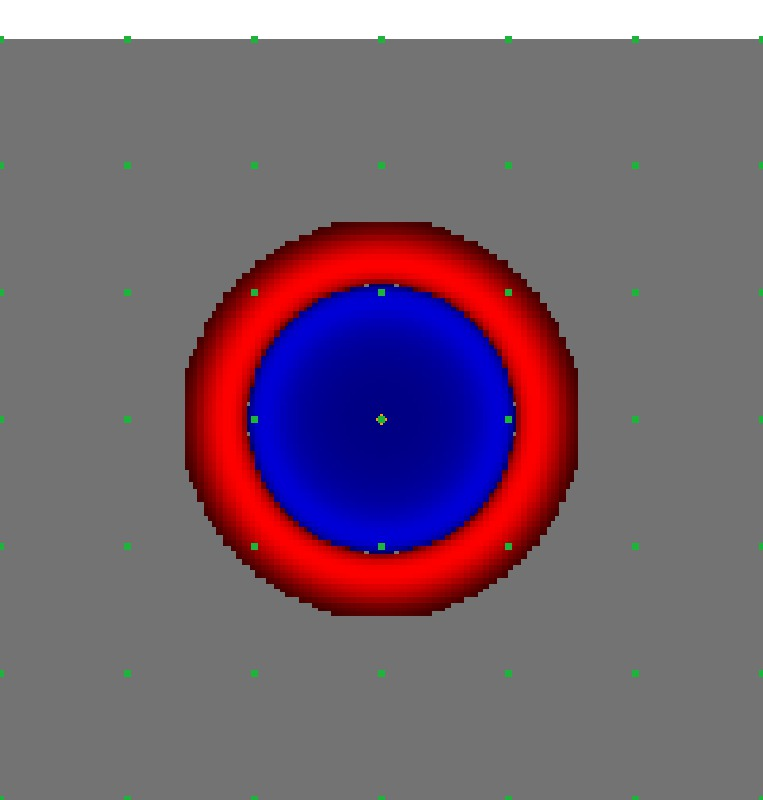

In [15]:
# Check your station configuration and source location
Image("OUTPUT_FILES/forward_image000001200.jpg")